Задача предсказания эмоций по тексту

https://www.geeksforgeeks.org/sentiment-classification-using-bert/ полезная ссылка

In [ ]:
!pip install catboost
!pip install ipywidgets  # визуализация
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
!pip install pyarrow
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import gensim.downloader
from gensim.models import Word2Vec

import torch
from torch import nn
import datasets
from datasets import set_caching_enabled
set_caching_enabled(False)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

from datasets import load_dataset
data = load_dataset("dair-ai/emotion", trust_remote_code=True)

<ipython-input-3-6e08bc4728e3>:10: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(False)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Баланс классов:

In [ ]:
unique_labels, counts = np.unique(data['train']['label'], return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Значение {label}: {count}")

Значение 0: 4666
Значение 1: 5362
Значение 2: 1304
Значение 3: 2159
Значение 4: 1937
Значение 5: 572


In [ ]:
labels = {'sadness':0,
          'joy':1,
          'love':2,
          'anger':3,
          'fear':4,
          'surprise':5
          }

In [ ]:
from sklearn.model_selection import train_test_split
X = data['train']['text']
y = data['train']['label']

In [ ]:
# fasttext-wiki-news-subwords-300
# conceptnet-numberbatch-17-06-300
# word2vec-ruscorpora-300
# word2vec-google-news-300
# glove-wiki-gigaword-50
# glove-wiki-gigaword-100
# glove-wiki-gigaword-200
# glove-wiki-gigaword-300
# glove-twitter-25
# glove-twitter-50
# glove-twitter-100
# glove-twitter-200

## word2vec-wiki-gigaword-200

In [ ]:
word2vec = gensim.downloader.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [ ]:
# усреднение слов: каждую строку разбиваем на токены, получили их эмбеддинги, после чего просуммировали и усреднили по всему тексту
def get_sentence_vector(row):
    token_list = row['text'].split()
    vector = np.zeros(shape=(word2vec.vector_size,))
    for token in token_list:
        vector += word2vec[token] if token in word2vec else np.zeros(shape=(word2vec.vector_size,))
    vector /= len(token_list)
    return {'vector' : vector}

data = data.map(get_sentence_vector)
data = data.with_format("np", columns=["vector", 'label'], output_all_columns=True)  # преобразуем тип в np для удобства

In [ ]:
data['train'][1]

## GloVe-twitter-100

Чем тяжелее модель, тем лучше качество

дефолт натсройки: 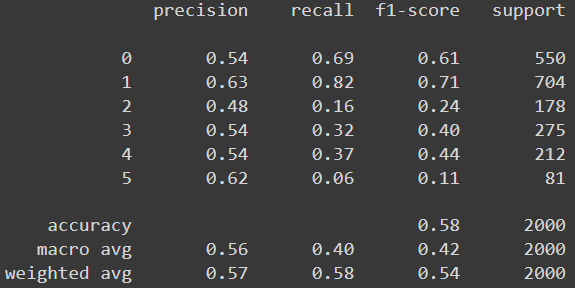

In [ ]:
word2vec_2 = gensim.downloader.load('glove-twitter-100')

def get_sentence_vector(row):
    token_list = row['text'].split()
    vector = np.zeros(shape=(word2vec_2.vector_size,))
    for token in token_list:
        if token in word2vec_2:
            vector += word2vec_2[token]
    vector /= len(token_list)
    return {'vector' : vector}

data = data.map(get_sentence_vector)
data = data.with_format("numpy", columns=["vector", 'label'], output_all_columns=True)

## Векторизация

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_try = CountVectorizer(stop_words='english', min_df=0.0003, ngram_range=(1, 4))
X_encoded = vectorizer_try.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_oversampled, y_train_oversampled = sampler.fit_resample(X_train, y_train)

# Модели

## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier()
param_xgb = {'max_depth': [2, 3, 4, 5], "min_child_weight": [1,3,5],
          "colsample_bytree":[0.3, 0.5, 0.7], 'n_estimators': [100, 200, 300, 500, 1000]}

xgb_cv = GridSearchCV(xgb, param_xgb, scoring='f1', cv=5)
xgb_cv.fit(data['train']['vector'], data['train']['label'].reshape(-1))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

def random_forest_classification(X_train, y_train, X_temp, y_temp):
    param_grid = {
        'n_estimators': [50, 100, 150, 200, 250],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 4, 6]
    }
    classifier = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters
    best_classifier = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Validation accuracy
    val_predictions = best_classifier.predict(X_temp)
    val_accuracy = accuracy_score(y_temp, val_predictions)
    print('\nValidation accuracy:', val_accuracy)

    # Classification report
    print(classification_report(y_temp, val_predictions))

    return best_classifier

In [ ]:
best_rf_classifier = random_forest_classification(X_train_oversampled, y_train_oversampled, X_temp, y_temp)

Best Parameters: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 250}

Validation accuracy: 0.8828125
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       946
           1       0.95      0.87      0.91      1021
           2       0.76      0.93      0.83       296
           3       0.84      0.91      0.87       427
           4       0.85      0.85      0.85       397
           5       0.68      0.90      0.78       113

    accuracy                           0.88      3200
   macro avg       0.83      0.89      0.86      3200
weighted avg       0.89      0.88      0.88      3200



5 класс всегда определяется хуже всего, тк обучающая выборка состоит всего из 1 примера. Другие классы тоже не могут похвастаться разнообразием данных

## HyperOpt

In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope
from functools import partial
from sklearn.model_selection import  cross_val_score, GridSearchCV, StratifiedKFold

search_space = {'xgb': {
                'params': {
                          'max_depth': scope.int(hp.uniform(label='max_depth', low=2, high=16)),
                          'optimizer': hp.choice('optimizer', ['adam', 'rms']),
                          'min_child_weight': scope.int(hp.quniform('min_child_weight', 2, 40, 1)),
                          'colsample_bytree': hp.uniform('colsample_by_tree', 0.3, 1.0),
                          'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
                          'n_estimators': scope.int(hp.uniform('n_estimators',100, 1000)),
                          'gamma': hp.uniform('gamma', 0.2, 1.0)
                          }
                }
                }

# метрики максимизации
score_list=['roc_auc','precision','f1']

def objective(parameters, X_train, y_train, r_state=23):
  model = XGBClassifier(random_state=r_state, **parameters['params'])
  kf = StratifiedKFold(n_splits=7)
  score = cross_val_score(estimator=model, X=X_norm, y=df1["Выжил"],
                          cv=kf, scoring=score_list[2], n_jobs=-1)

  return {'loss': -score.mean(), 'params': parameters['params'], 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=partial(objective, data['train']['vector'], data['train']['label'].reshape(-1), r_state=80),
            space=search_space['xgb'],
            algo=tpe.suggest,
            max_evals=300,
            trials=trials,
            show_progressbar=True
    )

In [ ]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame и выбираем лучшую понравившуюся комбинацию параметров
    """

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.loc[:, 'loss'] = results['loss'] * (-1)
    results.sort_values(by=['loss'], ascending=False, inplace=True, ignore_index=True)
    return results

results_hp = df_results(trials.results)
results_hp.head(20)

## VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

models = [
    ('lr', LogisticRegression(random_state=21)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist')),
    ('svc', SVC(kernel='linear', probability=True)),
    ('catboost', CatBoostClassifier(verbose=0))
]

voting_clf = VotingClassifier(estimators=models, voting='hard')
voting_clf.fit(X_train, y_train)


predictions = voting_clf.predict(data['validation']['vector'])

## BertTokenizer

In [ ]:
import torch
from datasets import load_dataset
from transformers import pipeline
import pandas as pd
import plotly.express as px

# classifier = pipeline("text-classification",model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')



class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

## Выводы

Модель на Glove-25
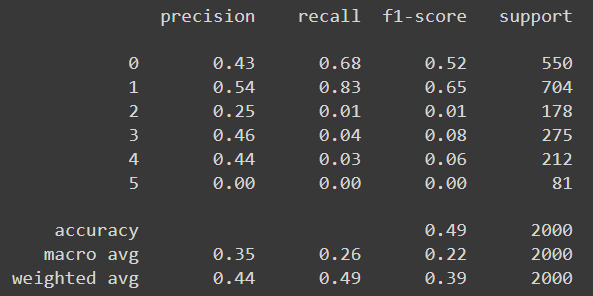

Модель на Glove-100
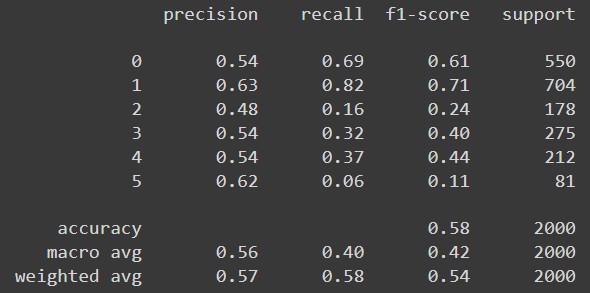

Модель - XBoost

RandomForest с векторизацией:
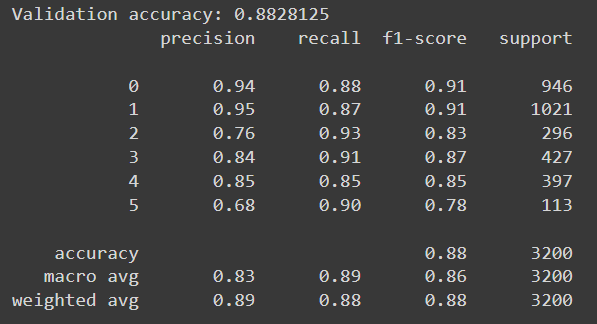

In [ ]:
5 класс имеет 2 примера в тренировочной выборке, поэтому определяется хуже всех